# ML Project (A.Y. 2020/21) by Dawit Mezemir Anelay and Marco Petix
## Cup Dataset

### Import Libraries

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

#keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras import initializers
import keras.backend as K

#sklearn (Sci-kit learn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer

# for combining all the hyper-parameters
import itertools

### Handling the dataset

In [2]:
#Extracting the training and test sets
train_df = pd.read_csv('data/ML-CUP20-TR.csv', header=None)
test_df = pd.read_csv('data/ML-CUP20-TS.csv', header=None)

#### Preprocessing

In [3]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,762.500000,-0.006309,0.020143,0.010106,0.003109,0.005619,0.023872,0.006110,-0.011253,0.007343,0.005921,48.474973,-28.571117
std,440.085219,1.041026,1.045854,1.040690,1.048153,1.026938,1.054734,1.051558,1.045984,1.034932,1.057754,15.218671,10.269957
min,1.000000,-2.247241,-2.158406,-2.068117,-3.190003,-2.657307,-3.467126,-2.167943,-2.435643,-2.298636,-2.325151,25.978398,-41.864859
25%,381.750000,-0.987447,-0.909239,-0.907696,-0.749282,-0.920508,-0.658990,-0.983262,-0.893817,-0.939021,-0.972809,34.666957,-36.935725
50%,762.500000,0.093405,0.062560,-0.023284,-0.030603,0.172423,-0.120652,0.136528,-0.005085,0.028914,0.208246,45.333403,-30.642449
75%,1143.250000,0.868999,0.894836,0.805138,0.695626,0.854577,0.701555,0.912320,0.783726,0.885435,0.829420,61.544593,-22.860160
max,1524.000000,2.289184,2.623750,2.846079,2.803400,2.250039,2.800493,2.679499,2.617978,2.526212,2.393244,78.836480,-4.064733


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1524 non-null   int64  
 1   1       1524 non-null   float64
 2   2       1524 non-null   float64
 3   3       1524 non-null   float64
 4   4       1524 non-null   float64
 5   5       1524 non-null   float64
 6   6       1524 non-null   float64
 7   7       1524 non-null   float64
 8   8       1524 non-null   float64
 9   9       1524 non-null   float64
 10  10      1524 non-null   float64
 11  11      1524 non-null   float64
 12  12      1524 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 154.9 KB


##### Correlations and primary feature selection

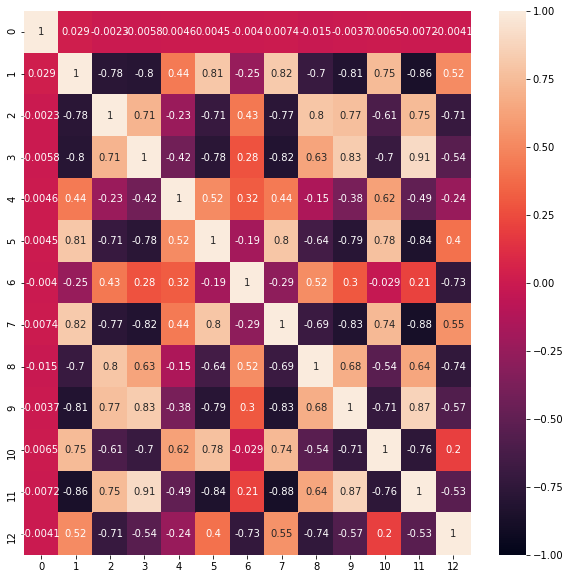

In [5]:
# correlation plot
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, annot= True,vmin=-1, vmax=1, ax=ax)
plt.show()

In [50]:
#Preparing train_df for training
train_dataset = train_df.to_numpy()[:, 1:11]
train_labelset = train_df.to_numpy()[:, 11:13]

#Preparing test_df for testing
test_dataset = test_df.to_numpy()[:, 1:11]

##### Correlations analysis: negative correlation
A negative (inverse) correlation occurs when the correlation coefficient is less than 0. This is an indication that both variables move in the opposite direction. In short, any reading between 0 and -1 means that the two securities move in opposite directions. When ρ is -1, the relationship is said to be perfectly negatively correlated. In short, if one variable increases, the other variable decreases with the same magnitude (and vice versa). However, the degree to which two securities are negatively correlated might vary over time (and they are almost never exactly correlated all the time).

##### Correlations analysis: positive correlation
A positive correlation—when the correlation coefficient is greater than 0—signifies that both variables move in the same direction. When ρ is +1, it signifies that the two variables being compared have a perfect positive relationship; when one variable moves higher or lower, the other variable moves in the same direction with the same magnitude.

Some basic takeaways from the correlation matrix are as follows: 1 all white squares indicate high correlation between the corresponding variables 2 "X2" and "X3" show high corelation(0.71) both seem to have a similar (and relatively high) correlation with "Y1" and low correlation wiht "Y2" This shows a clear case of multicollinearity. Thus we can remove one of them and retain the other. 3 "X1" and "X5" show high corelation(0.8) both seem to have a similar (and relatively high) correlation with "Y1" and low correlation with "Y2" This shows a clear case of multicollinearity. Thus we can remove one of them and retain the other. 4 "X2" and "X8" show multicolinearity .Thus we can remove one of the and retain the other . 5 "X9" and "X8" show multicolinearity. Thus we can remove one of the and retain the other.

##### Features elimination

In [7]:
# dropping highly correlated features
train_dataset_r = pd.DataFrame(train_dataset).drop(columns=[0,1,7])

In [51]:
test_dataset_r = pd.DataFrame(test_dataset).drop(columns=[0,1,7])

#### Dataset splitting 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset_r, train_labelset, test_size=0.25)

### Definining useful functions

In [9]:
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [10]:
def mean_euclidean_error(y_true, y_pred):
    error = 0
    if(len(y_true) == len(y_pred)):
        for i in range(len(y_true)):
            error = error + np.sqrt(np.square(y_pred[i][0] - y_true[i][0]) + np.square(y_pred[i][1] - y_true[i][1]))
        return error / len(y_true)

In [11]:
### Model Definition
def create_model(
                    lr=0.3, 
                    num_hidden_units=10,
                    activation_hidden="sigmoid",
                    second_layer=False,
                    num_hidden_units2=10,
                    activation_hidden2="sigmoid", 
                    activation_out="linear",
                    init_mode=initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal"),
                    momentum=0.0, 
                    decay=0.0
                ):
    # create model
    model = Sequential()
    model.add(Dense(units=num_hidden_units, input_dim=7, kernel_initializer=init_mode, activation=activation_hidden))
    if second_layer:
        model.add(Dense(units=num_hidden_units2, activation=activation_hidden2))
    model.add(Dense(2, activation=activation_out)) 

    #optimizer
    optimizer = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)

    # Compile model
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=['accuracy'])
    return model

In [12]:
# methods for the screening phase 
def plot_loss(history, title, ax, label='VL', loss='MEE'):
    plt.subplot(ax)
    plt.plot(history.history['loss'], label='TR', linewidth=3.0, ls='solid', c='red')
    plt.plot(history.history['val_loss'], label=label, linewidth=3.0, ls='dotted', c='blue')
    ax.set_title(loss + ': ' + title, fontsize=16)
    ax.set_ylabel(loss, fontsize=20)
    ax.set_xlabel('Epoch', fontsize=20)
    ax.legend(loc='best', prop={"size":20})
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)

In [13]:
def screening_phase(par_a, values_a, par_b, values_b, fixed_params=dict(), plot_function=plot_loss, epochs=100, batch_size=10):
    num_values_a = len(values_a)
    num_values_b = len(values_b)
    f, axs = plt.subplots(nrows=num_values_a, ncols=num_values_b, figsize=(8*num_values_b, 5*num_values_a))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for i in range(num_values_a):
        for j in range(num_values_b):
            params = fixed_params.copy()
            params[par_a] = values_a[i]
            params[par_b] = values_b[j]
            model = KerasRegressor(build_fn=create_model, **params)
            history = model.fit(X_train, y_train, validation_split=0.33, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)
            plot_title = '[' + par_a + '=' + str(values_a[i]) + '][' + par_b + '=' + str(values_b[j]) + ']'
            plot_function(history, plot_title, axs[i][j])
    plt.show()

def screening_phase_single(par, values, fixed_params=dict(), plot_function=plot_loss, epochs=100, batch_size=10, labels=None):
    f, axs = plt.subplots(ncols=len(values), figsize=(8*len(values), 5))
    for i in range(len(values)):
        params = fixed_params.copy()
        params[par] = values[i]
        model = KerasRegressor(build_fn=create_model, **params)
        history = model.fit(X_train, y_train, validation_split=0.33, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)
        if labels:
            plot_title = '[' + par + '=' + labels[i] + ']'
        else:
            plot_title = '[' + par + '=' + str(values[i]) + ']'
        plot_function(history, plot_title, axs[i])
    plt.show()

### Screening Phase

In [14]:
fixed_params = dict()

#### Screening phase on the weights initialization mode

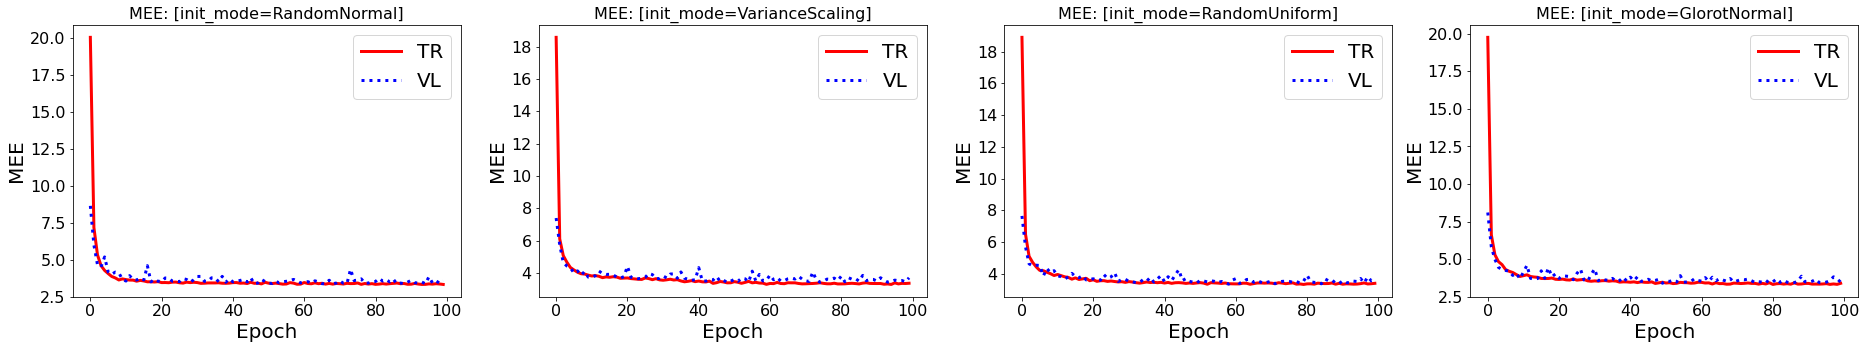

In [15]:
init_modes = [
    initializers.RandomNormal(mean=0., stddev=1.),
    initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal"),
    initializers.RandomUniform(minval=-0.5, maxval=0.5),
    initializers.GlorotNormal() ]

init_names = ['RandomNormal', 'VarianceScaling', 'RandomUniform', 'GlorotNormal']

screening_phase_single('init_mode', init_modes, labels=init_names)

In [16]:
fixed_params['init_mode'] = initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")

#### Screening phase on the number of units and activation function of the first hidden layer

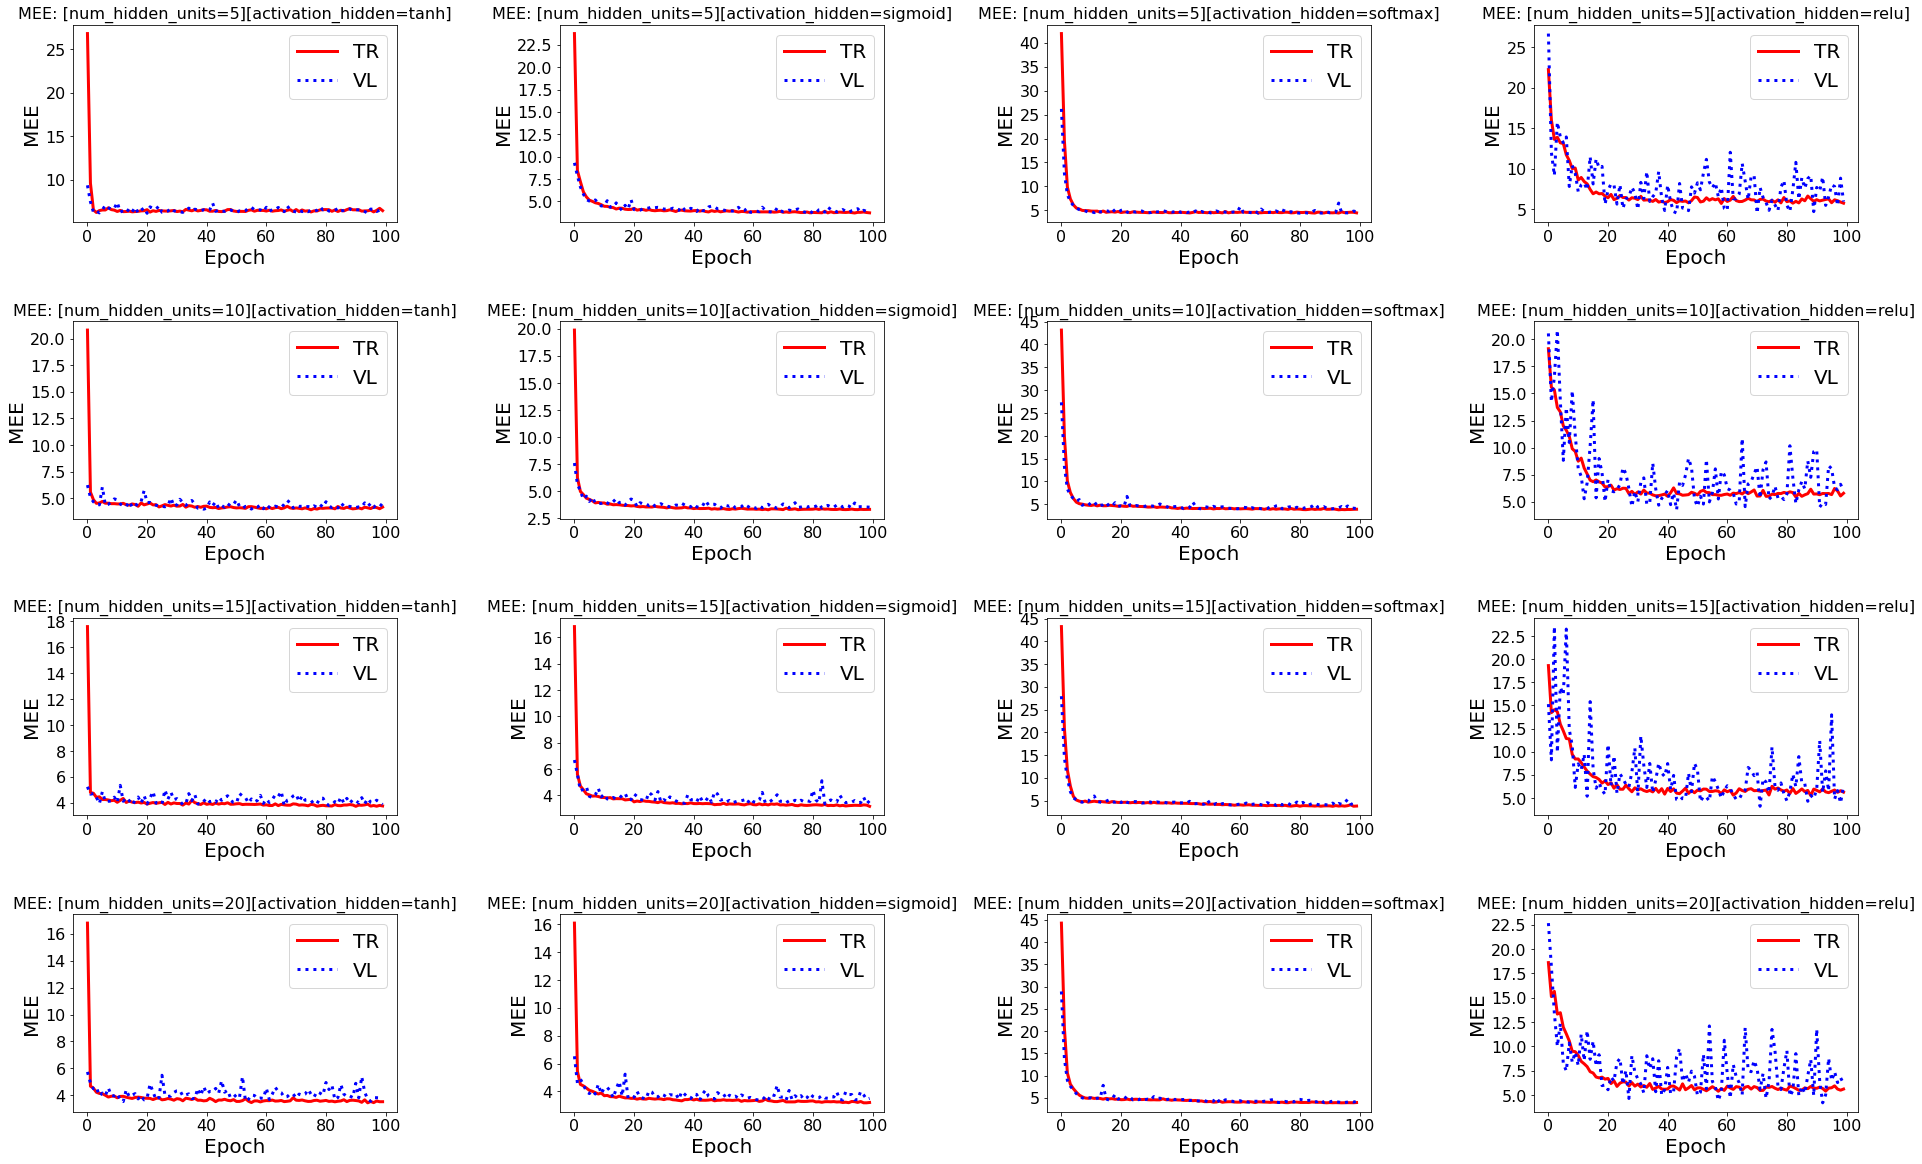

In [17]:
screening_phase('num_hidden_units', [5, 10, 15, 20], 'activation_hidden', ['tanh', 'sigmoid', 'softmax', 'relu'], fixed_params)

In [18]:
# sigmoid, softmax and tanh are candidates for the activation function of the first layer
fixed_params['activation_hidden'] = 'sigmoid'
# need more tests for the number of units of the first layer
fixed_params['num_hidden_units'] = 15

#### Screening phase on the learning rate and momentum

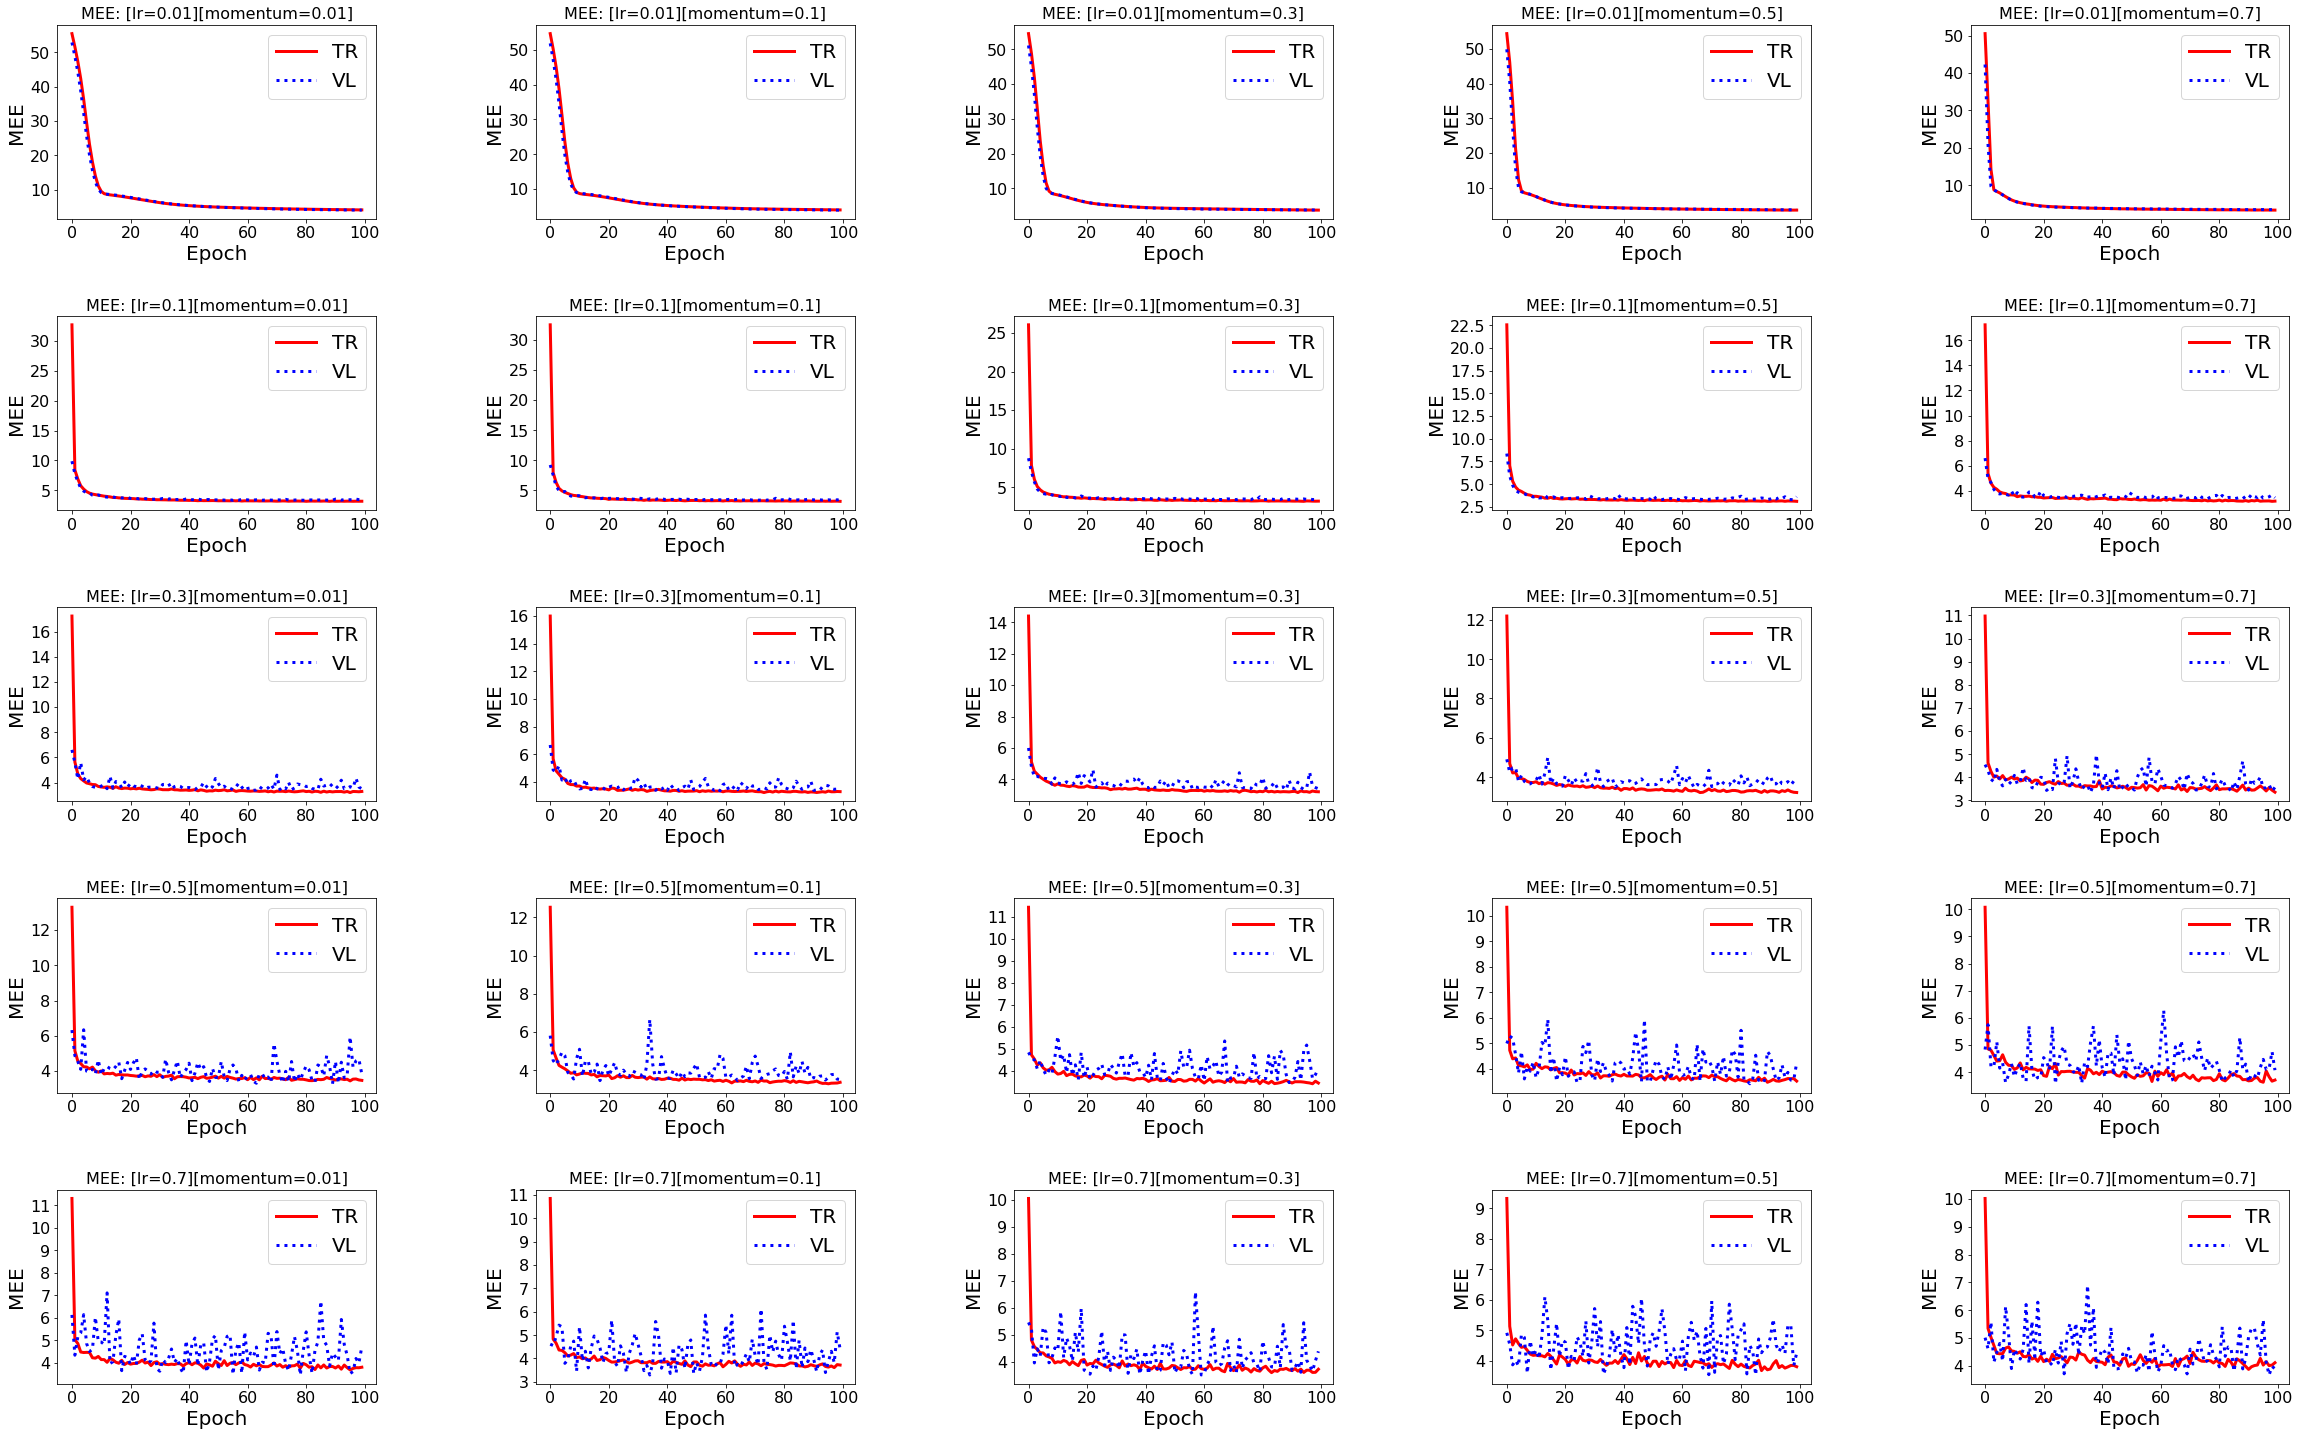

In [19]:
screening_phase('lr', [0.01, 0.1, 0.3, 0.5, 0.7], 'momentum', [0.01, 0.1, 0.3, 0.5, 0.7], fixed_params)

In [20]:
# learning rate 0.3 and momentum 0.7 seems promising but unstable, the same for lr 0.5 and momentum 0.3
fixed_params['lr'] = 0.5
# momentum
fixed_params['momentum'] = 0.3

#### Screening phase on the decay and momentum

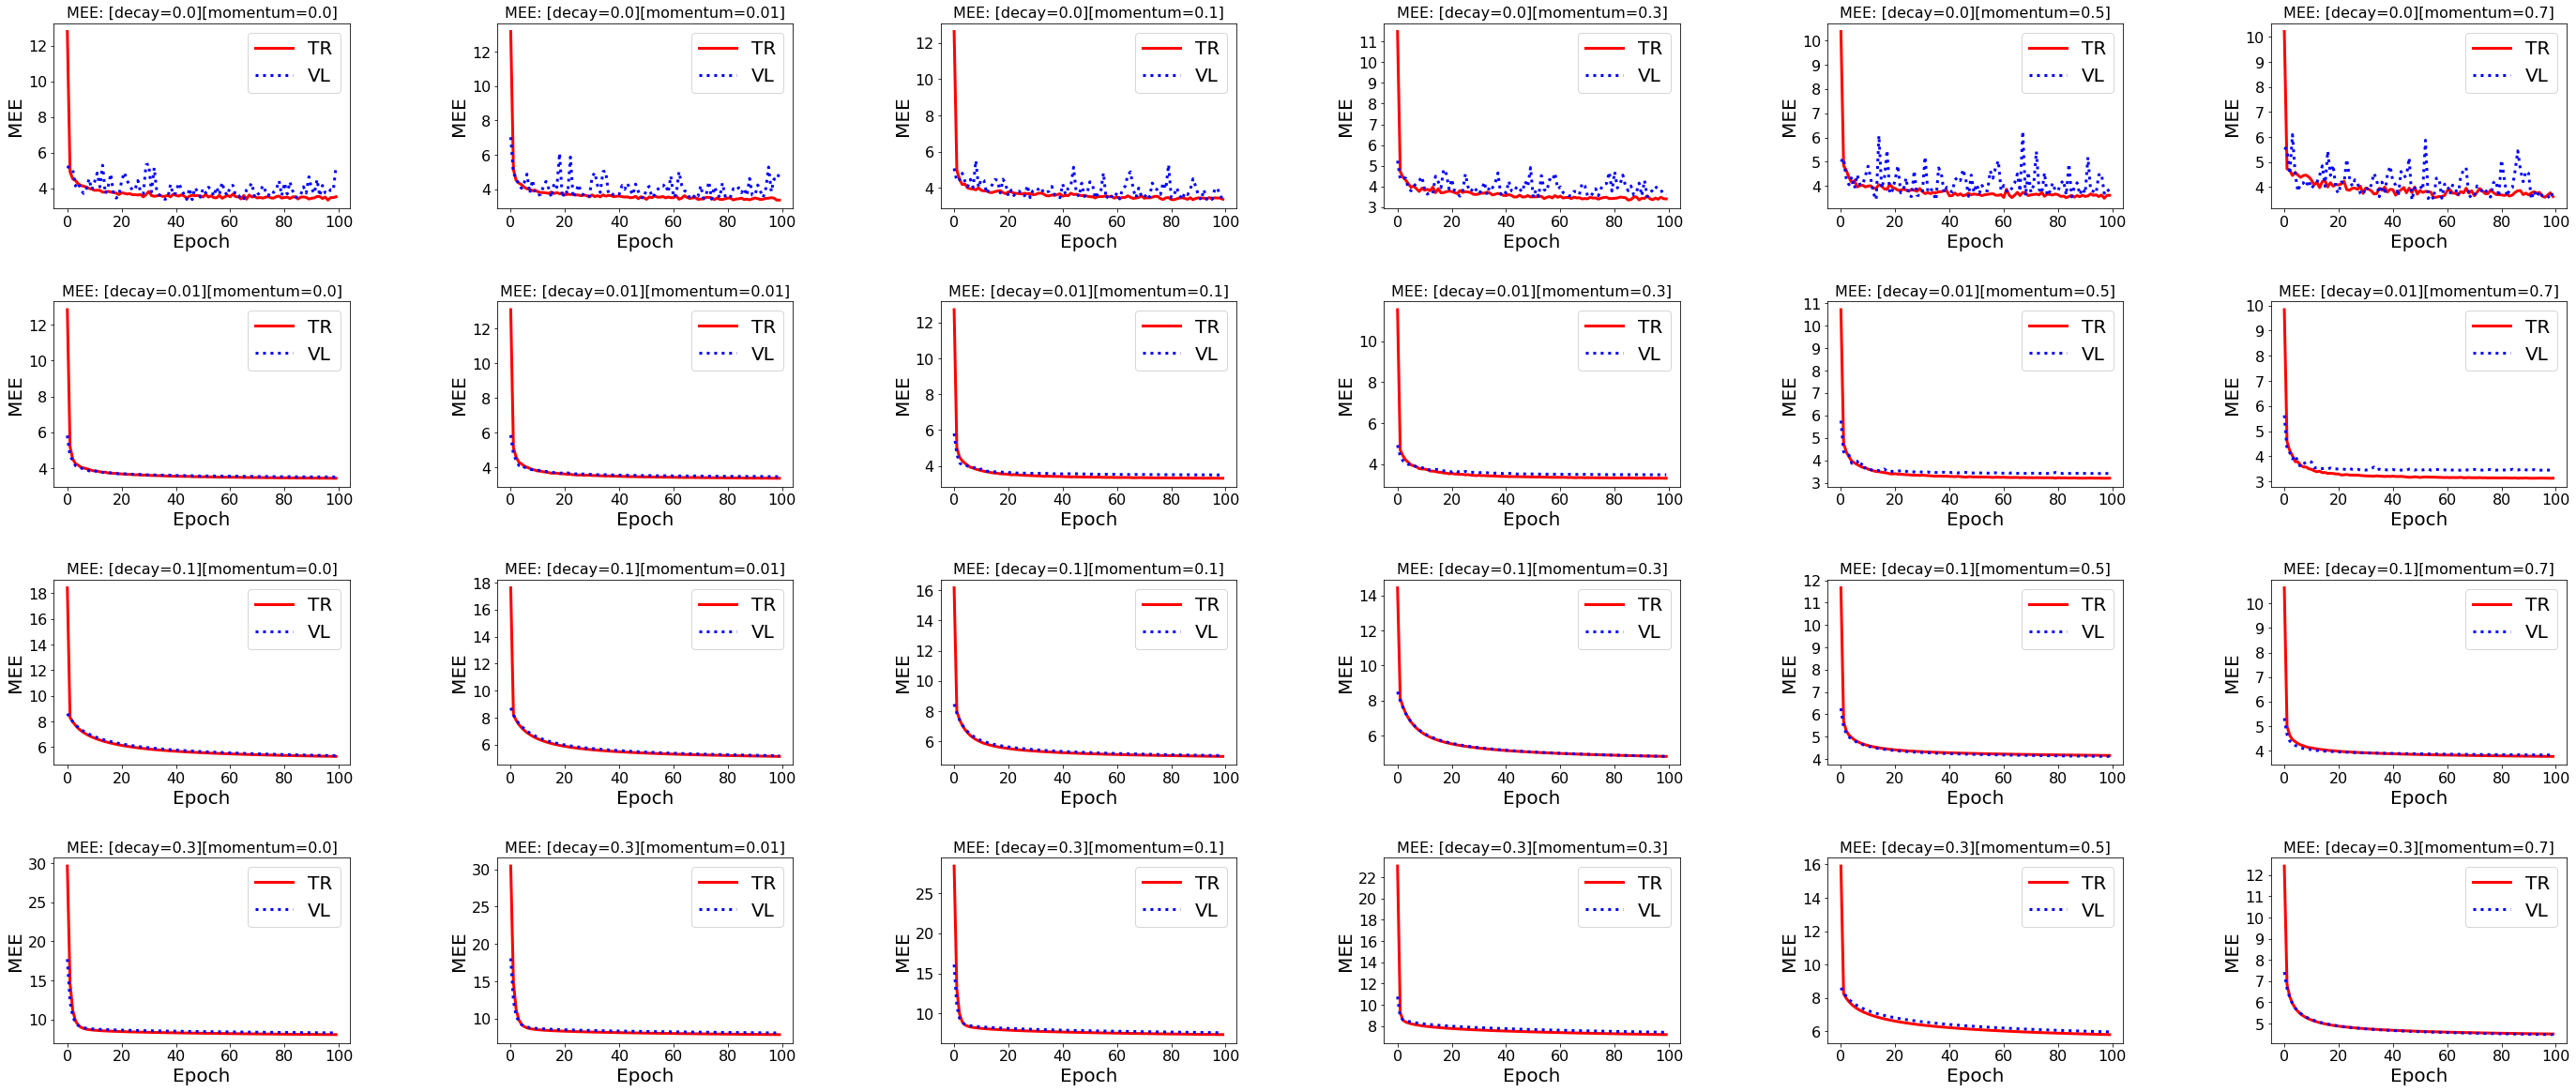

In [21]:
screening_phase('decay', [0.0, 0.01, 0.1, 0.3], 'momentum', [0.0, 0.01, 0.1, 0.3, 0.5, 0.7], fixed_params)

In [22]:
fixed_params['decay'] = 0.01
fixed_params['momentum'] = 0.5

#### Screening phase on the number of units and the activation function of the second layer 

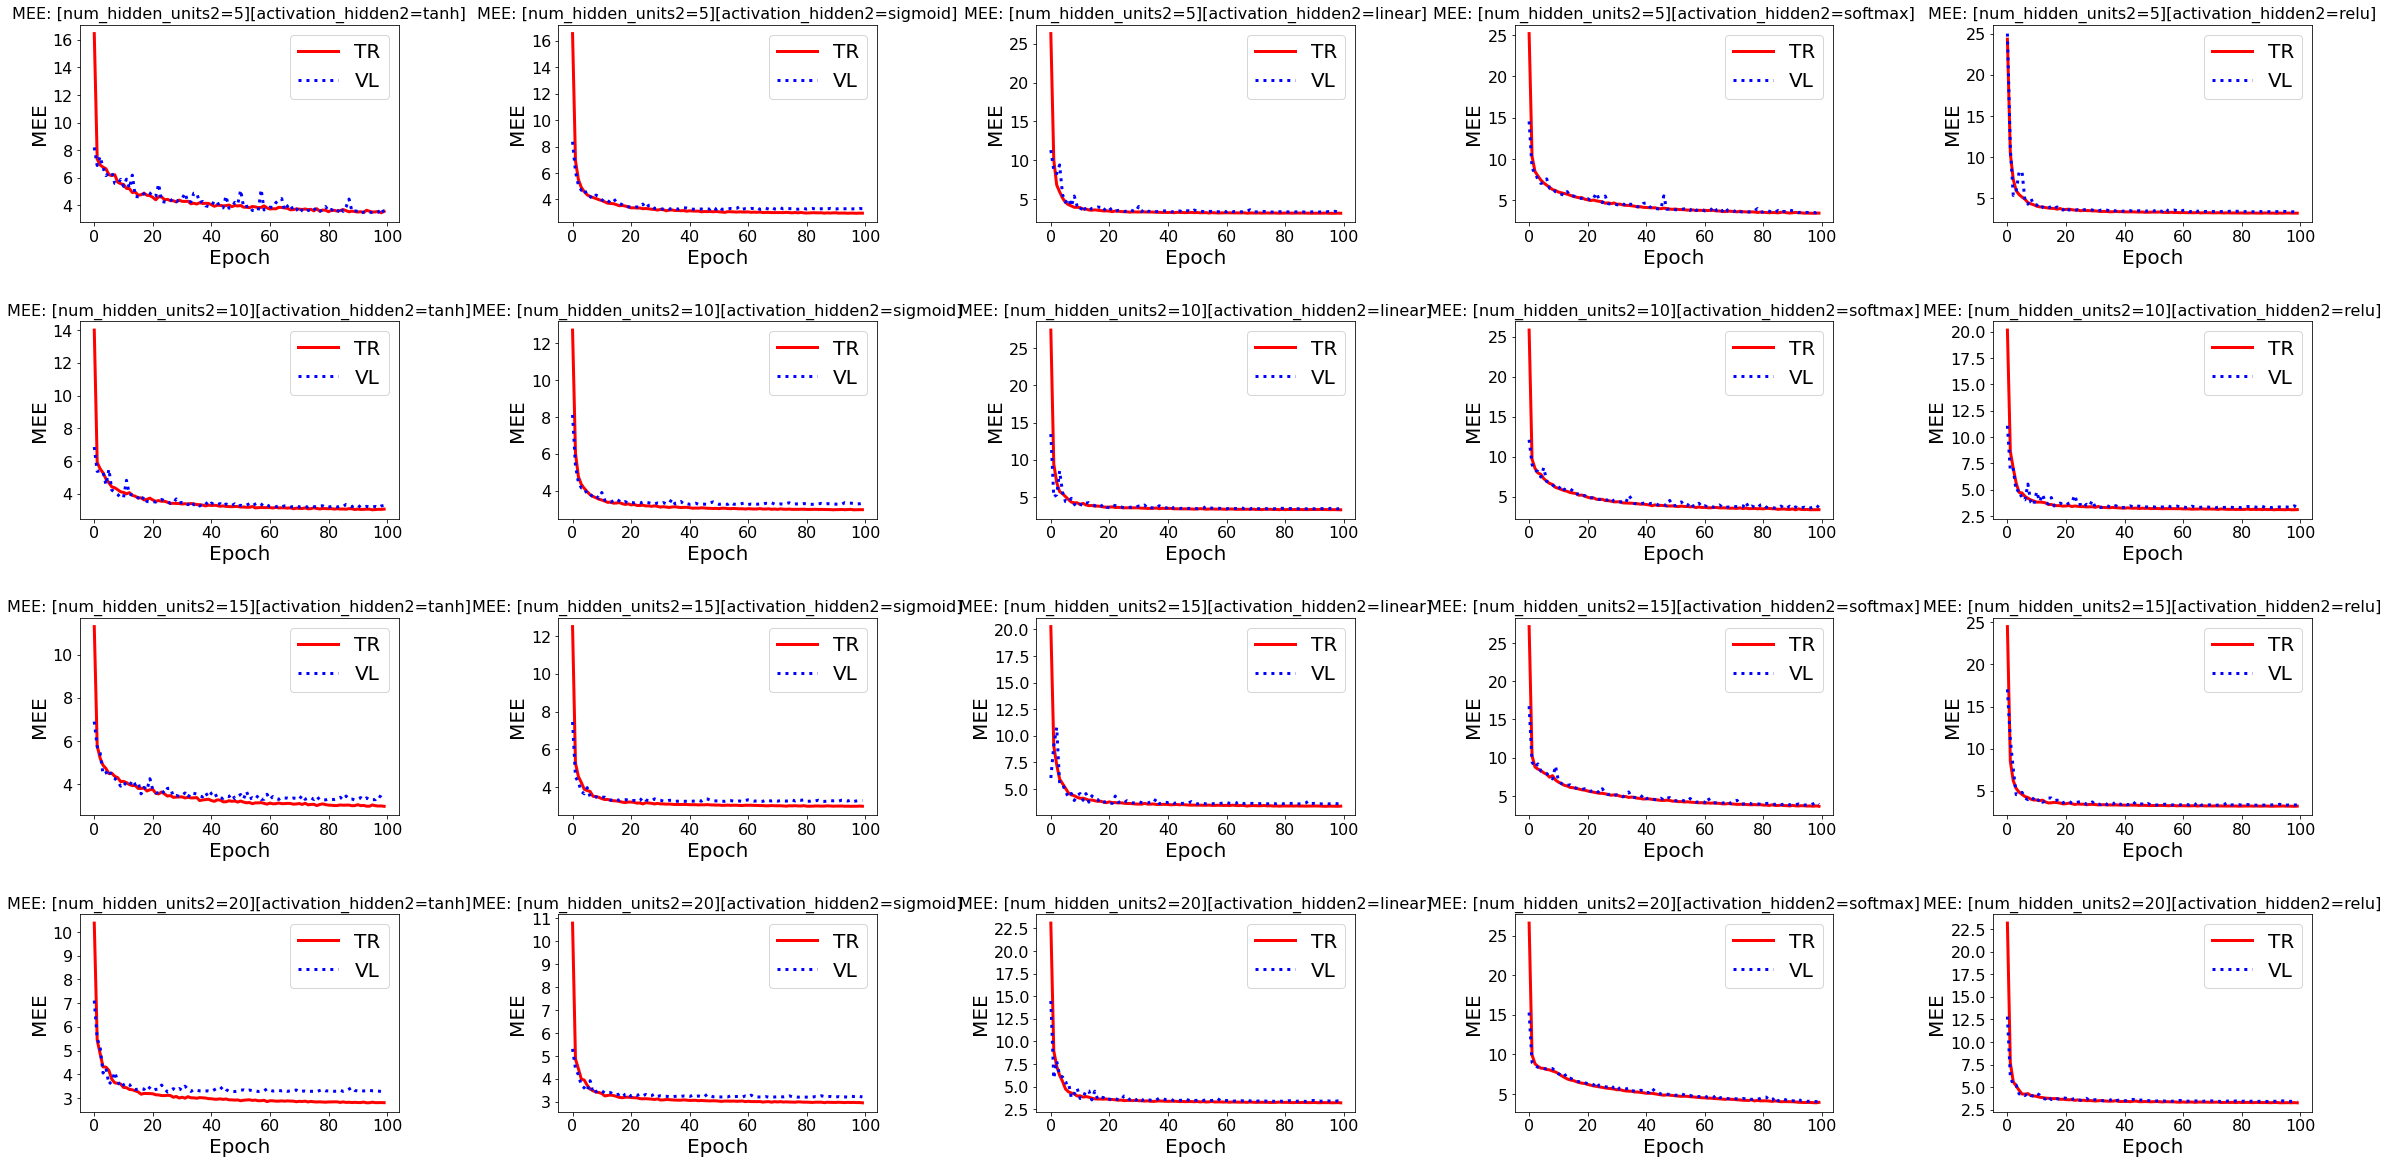

In [29]:
fixed_params['second_layer'] = True
screening_phase('num_hidden_units2', [5, 10, 15, 20], 'activation_hidden2', ['tanh', 'sigmoid', 'linear', 'softmax', 'relu'], fixed_params)

##### A better look at the behaviour of the linear and relu functions

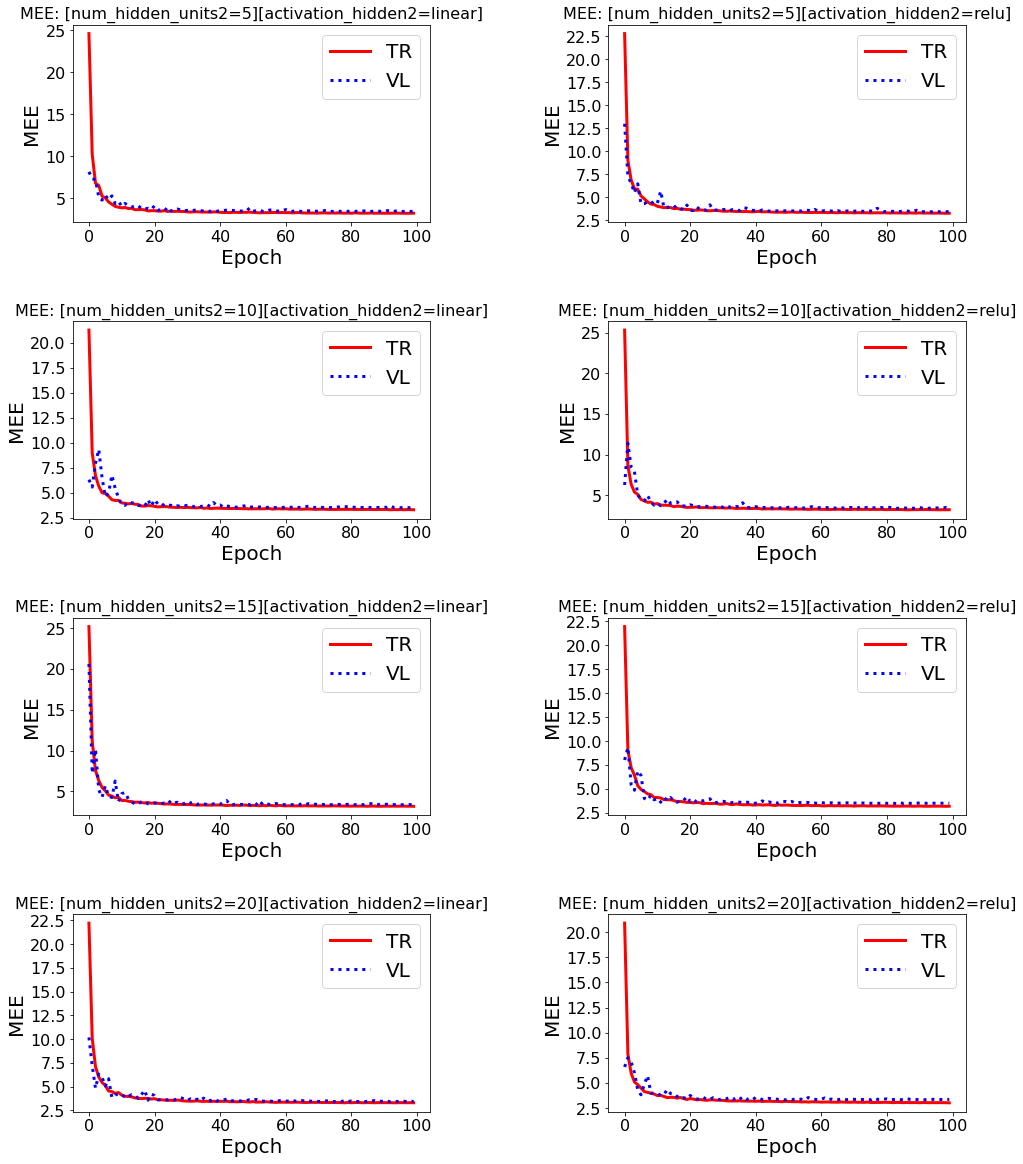

In [30]:
#let's take a better look at linear and relu
screening_phase('num_hidden_units2', [5, 10, 15, 20], 'activation_hidden2', ['linear', 'relu'], fixed_params)

In [31]:
fixed_params['num_hidden_units2'] = 10
fixed_params['activation_hidden2'] = 'linear'

#### Screening phase on the epochs and batch size

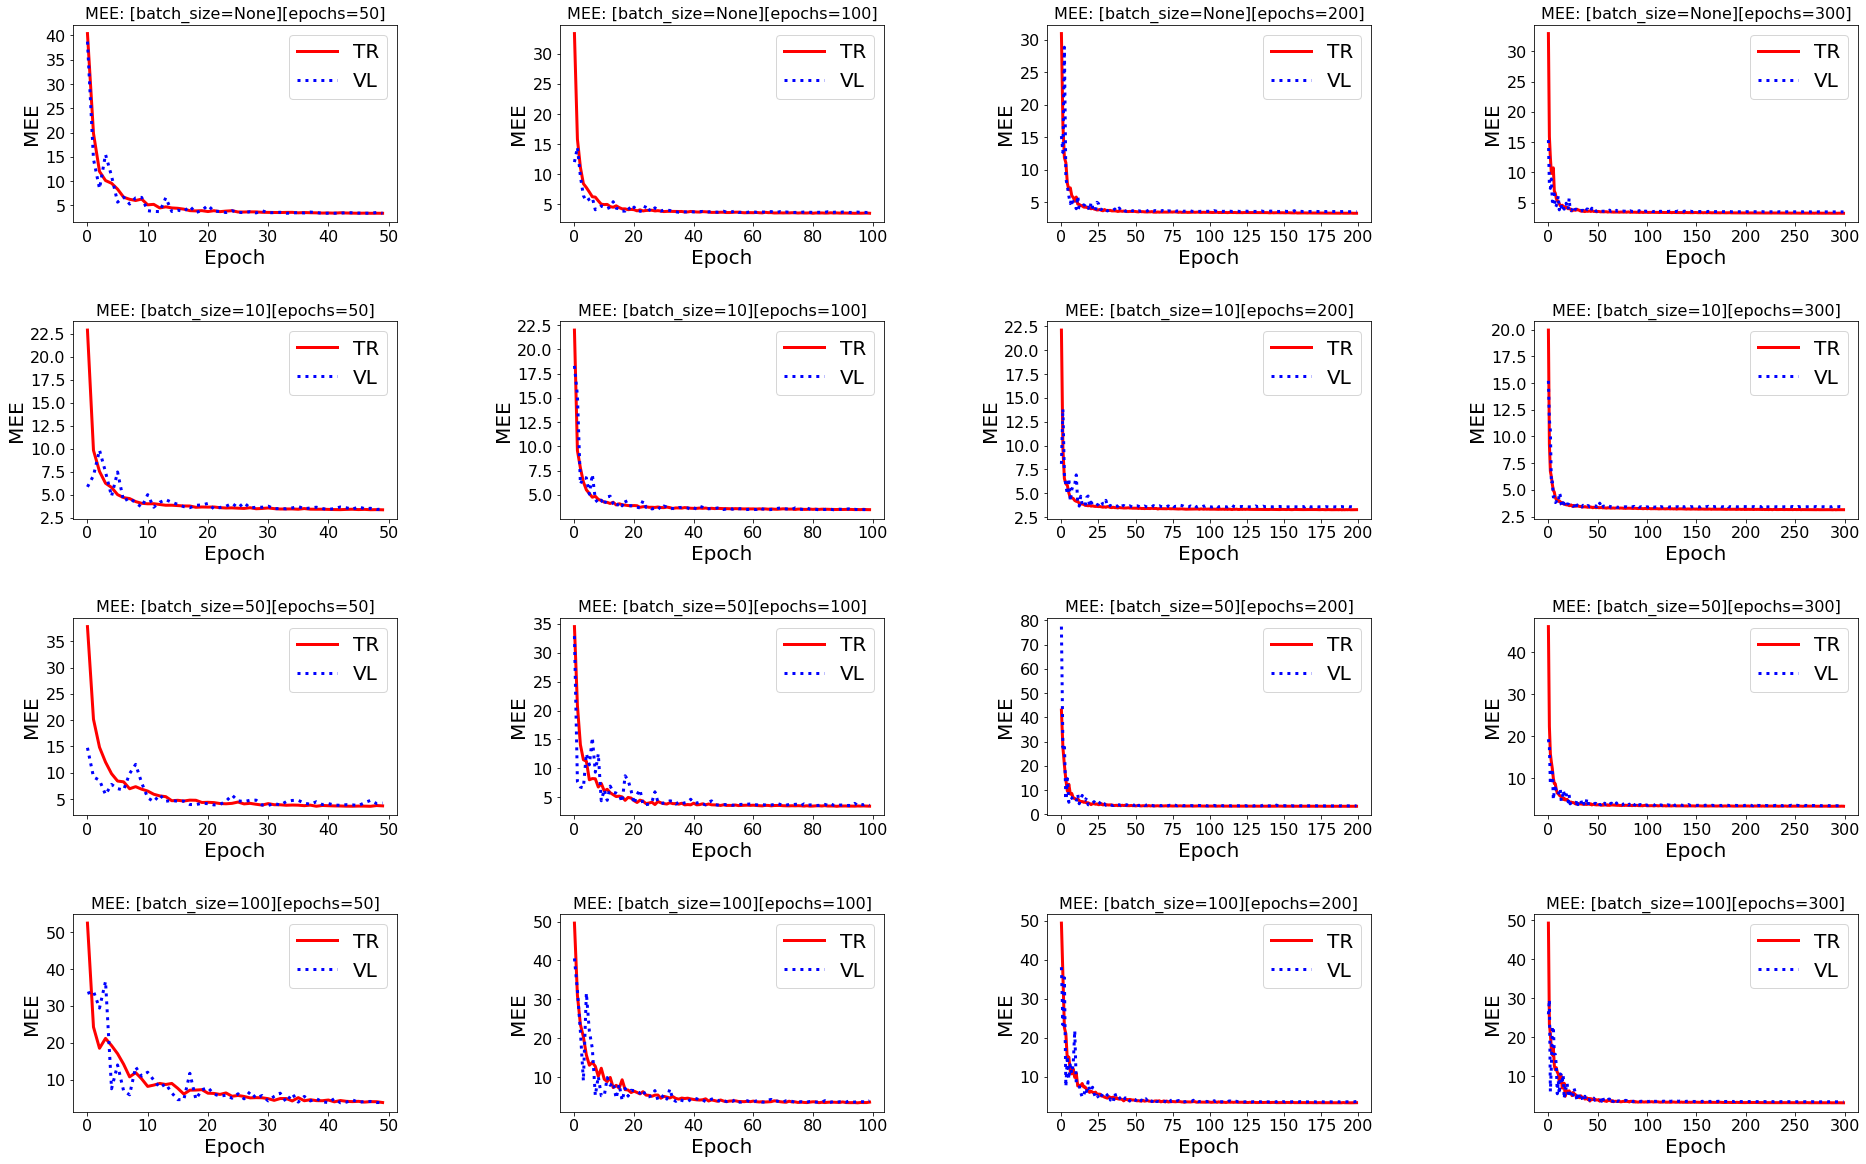

In [34]:
batch_sizes = [None, 10, 50, 100]
epochs = [50, 100, 200, 300]

num_values_a = len(batch_sizes)
num_values_b = len(epochs)
f, axs = plt.subplots(nrows=num_values_a, ncols=num_values_b, figsize=(8*num_values_b, 5*num_values_a))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(num_values_a):
    for j in range(num_values_b):
        model = KerasRegressor(build_fn=create_model, **fixed_params)
        history = model.fit(X_train, y_train, validation_split=0.33, shuffle=True, epochs=epochs[j], batch_size=batch_sizes[i], verbose=0)
        plot_title = '[' + 'batch_size' + '=' + str(batch_sizes[i]) + '][epochs=' + str(epochs[j]) + ']'
        plot_loss(history, plot_title, axs[i][j])
plt.show()

### Model's parameters after the screening phase

In [33]:
fixed_params

{'init_mode': <tensorflow.python.keras.initializers.initializers_v2.VarianceScaling at 0x2205ff52fa0>,
 'activation_hidden': 'sigmoid',
 'num_hidden_units': 15,
 'lr': 0.5,
 'momentum': 0.5,
 'decay': 0.01,
 'second_layer': True,
 'num_hidden_units2': 10,
 'activation_hidden2': 'linear'}

### Grid-Search

#### Defining the grid space

In [26]:
### Grid-search
# define the grid search parameters
space = {}
space['lr'] = [0.4, 0.5, 0.6]
space['num_hidden_units'] = [10, 15, 20]
space['num_hidden_units2'] = [5, 10, 15]
space['activation_hidden'] = ['sigmoid']
space['activation_hidden2'] = ['linear', 'relu']
space['activation_out'] = ['linear']
space['momentum'] = [0.4, 0.5, 0.6]
space['decay'] = [0.01, 0.1]
space['epochs'] = [100, 200, 300] 
space['batch_size'] = [10, 15, 20]

#### Running the grid-search

In [28]:
mee = make_scorer(mean_euclidean_error, greater_is_better=False)

In [59]:
start=time()
model = KerasRegressor(build_fn=create_model) 
grid = GridSearchCV(estimator=model, param_grid=space, n_jobs=-1, cv=3, verbose=2, scoring=mee)
grid_result = grid.fit(train_dataset_r, train_labelset)
end=time()

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 105.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 130.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 155.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 179.2min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 214.7min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 271.7min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 306.8min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 346.6min
[Parallel(n_jobs=-1)]: Done 8748 out o

Epoch 1/300
153/153 [==============================] - 1s 509us/step - loss: 12.3760 - accuracy: 0.9635
Epoch 2/300
153/153 [==============================] - 0s 494us/step - loss: 4.1670 - accuracy: 1.0000
Epoch 3/300
153/153 [==============================] - 0s 512us/step - loss: 3.7517 - accuracy: 1.0000
Epoch 4/300
153/153 [==============================] - 0s 530us/step - loss: 3.5781 - accuracy: 1.0000
Epoch 5/300
153/153 [==============================] - 0s 534us/step - loss: 3.6025 - accuracy: 1.0000
Epoch 6/300
153/153 [==============================] - 0s 507us/step - loss: 3.4695 - accuracy: 1.0000
Epoch 7/300
153/153 [==============================] - 0s 522us/step - loss: 3.3919 - accuracy: 1.0000
Epoch 8/300
153/153 [==============================] - 0s 502us/step - loss: 3.4732 - accuracy: 1.0000
Epoch 9/300
153/153 [==============================] - 0s 518us/step - loss: 3.4226 - accuracy: 1.0000
Epoch 10/300
153/153 [==============================] - 0s 518us/step - 

#### Analysing the grid-search results

In [60]:
print("Total Running Time: %f", end - start)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Total Running Time: %f 22383.426990509033
Best: -3.370774 using {'activation_hidden': 'sigmoid', 'activation_hidden2': 'linear', 'activation_out': 'linear', 'batch_size': 10, 'decay': 0.01, 'epochs': 300, 'lr': 0.6, 'momentum': 0.6, 'num_hidden_units': 20, 'num_hidden_units2': 15}


#### Defining the best model

In [46]:
# create model
model = Sequential()
model.add(Dense(units=20, input_dim=7, kernel_initializer=initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal"), activation='sigmoid'))
model.add(Dense(units=15, activation='linear'))
model.add(Dense(2, activation='linear')) 
#optimizer
optimizer = SGD(lr=0.6, momentum=0.6, decay=0.01, nesterov=False)
# Compile model
model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=['accuracy'])

### Performance on the internal test set

Epoch 1/300
115/115 [==============================] - 0s 2ms/step - loss: 42.2752 - accuracy: 0.8624 - val_loss: 9.8580 - val_accuracy: 1.0000
Epoch 2/300
115/115 [==============================] - 0s 911us/step - loss: 8.4924 - accuracy: 1.0000 - val_loss: 12.4850 - val_accuracy: 1.0000
Epoch 3/300
115/115 [==============================] - 0s 910us/step - loss: 6.6887 - accuracy: 1.0000 - val_loss: 4.3837 - val_accuracy: 1.0000
Epoch 4/300
115/115 [==============================] - 0s 932us/step - loss: 5.2204 - accuracy: 1.0000 - val_loss: 5.9073 - val_accuracy: 1.0000
Epoch 5/300
115/115 [==============================] - 0s 900us/step - loss: 4.8490 - accuracy: 1.0000 - val_loss: 4.4514 - val_accuracy: 1.0000
Epoch 6/300
115/115 [==============================] - 0s 1ms/step - loss: 4.3065 - accuracy: 1.0000 - val_loss: 5.5103 - val_accuracy: 1.0000
Epoch 7/300
115/115 [==============================] - 0s 897us/step - loss: 4.4142 - accuracy: 1.0000 - val_loss: 3.9427 - val_accu

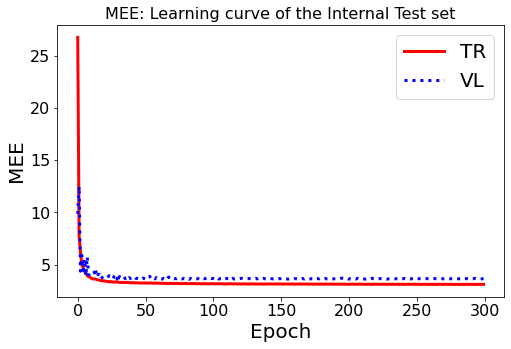

In [47]:
f, ax = plt.subplots(figsize=(8, 5))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True, epochs=300, batch_size=10, verbose=1)
plot_title = 'Learning curve of the Internal Test set'
plot_loss(history, plot_title, ax)

#### Extra: analysing the performance on the originial dataset

Epoch 1/300
115/115 [==============================] - 1s 2ms/step - loss: 41.0491 - accuracy: 0.8909 - val_loss: 28.0156 - val_accuracy: 1.0000
Epoch 2/300
115/115 [==============================] - 0s 896us/step - loss: 11.2340 - accuracy: 1.0000 - val_loss: 10.0979 - val_accuracy: 1.0000
Epoch 3/300
115/115 [==============================] - 0s 917us/step - loss: 6.5274 - accuracy: 1.0000 - val_loss: 4.8856 - val_accuracy: 1.0000
Epoch 4/300
115/115 [==============================] - 0s 926us/step - loss: 4.8768 - accuracy: 1.0000 - val_loss: 3.8233 - val_accuracy: 1.0000
Epoch 5/300
115/115 [==============================] - 0s 932us/step - loss: 4.0793 - accuracy: 1.0000 - val_loss: 5.6761 - val_accuracy: 1.0000
Epoch 6/300
115/115 [==============================] - 0s 939us/step - loss: 4.0079 - accuracy: 1.0000 - val_loss: 4.8338 - val_accuracy: 1.0000
Epoch 7/300
115/115 [==============================] - 0s 907us/step - loss: 3.6836 - accuracy: 1.0000 - val_loss: 4.3309 - val_

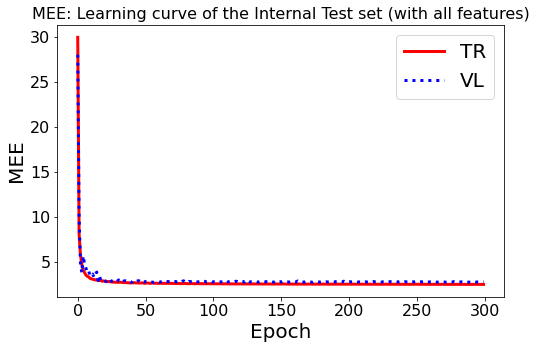

In [48]:
# create model
model_2 = Sequential()
model_2.add(Dense(units=20, input_dim=10, kernel_initializer=initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal"), activation='sigmoid'))
model_2.add(Dense(units=15, activation='linear'))
model_2.add(Dense(2, activation='linear')) 
#optimizer
optimizer_2 = SGD(lr=0.6, momentum=0.6, decay=0.01, nesterov=False)
# Compile model
model_2.compile(optimizer=optimizer_2, loss=euclidean_distance_loss, metrics=['accuracy'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train_dataset, train_labelset, test_size=0.25)
f, ax = plt.subplots(figsize=(8, 5))
history_with_all_features = model_2.fit(X_train_2, y_train_2, validation_data=(X_test_2, y_test_2), shuffle=True, epochs=300, batch_size=10, verbose=1)
plot_title = 'Learning curve of the Internal Test set (with all features)'
plot_loss(history_with_all_features, plot_title, ax)

### Performing the regression task on the actual test set 

In [53]:
test_pred_r = model.predict(test_dataset_r)

In [54]:
test_pred = model_2.predict(test_dataset)

#### Exporting the predictions